In [1]:
%matplotlib inline

import re
import cv2
import glob

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
path = "Signs/Final_Training/Images/"

sign_labels_dict = {
    "00000" : "20km/h",
    "00001" : "30km/h",
    "00002" : "50km/h",
    "00003" : "60km/h",
    "00004" : "70km/h",
    "00005" : "80km/h",
    "00006" : "end 80km/h",
    "00007" : "100km/h",
    "00008" : "120km/h",
    "00009" : "No pass",
    "00010" : "Passing to 3.5 metres",
    "00011" : "Right-of-way",
    "00012" : "Priority",
    "00013" : "Yield",
    "00014" : "Stop",
    "00015" : "No cars",
    "00016" : "To 3.5 tons",
    "00017" : "No pass",
    "00018" : "Caution",
    "00019" : "Left curve",
    "00020" : "Right curve",
    "00021" : "2 curves",
    "00022" : "Bumpy",
    "00023" : "Slippery road",
    "00024" : "Road narrows on the right",
    "00025" : "Road work",
    "00026" : "Traffic signals",
    "00027" : "Pedestrians",
    "00028" : "Children",
    "00029" : "Bicycles",
    "00030" : "Snow",
    "00031" : "Animals",
    "00032" : "End of limits",
    "00033" : "Turn right",
    "00034" : "Turn left",
    "00035" : "Straight",
    "00036" : "Straight or right",
    "00037" : "Straight or left",
    "00038" : "Keep right",
    "00039" : "Keep left",
    "00040" : "Traffic circle",
    "00041" : "End of no passing",
    "00042" : "End of no passing by vechiles over 3.5 metric tons"
}

In [3]:
#dataset http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
def load_data(path):
    images = {}
    for directory in glob.glob(path+"*"):
        sign_one_type = []
        for filename in glob.glob(directory+'/*.ppm'): 
            image = cv2.imread(filename) 
            #Why gray? http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(gray_image, (32, 32)) 
            sign_one_type.append(resized_image)
        images[directory] = sign_one_type
    return images

def plot_bar(converted_dataset, title):
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    plt.xlabel('Sign name', fontsize=18)
    plt.ylabel('Number of signs in set', fontsize=18)
    plt.title(title)
    plt.grid(True)
    plt.bar(list(converted_dataset.keys()), converted_dataset.values(), color='g', )
    plt.show()

def print_signs(images):
    for label in images.keys():
        print(label)
        i = 0
        for image in images[label]:
            plt.imshow(image, cmap="gray")
            plt.show()
            if i > 15:
                break
            i = i + 1
        
def create_plot_date(dataset, sign_labels_dict):
    sign_labels_dict = {path+k: v for k,v in sign_labels_dict.items()}
    plot_dict = {}
    for key in dataset.keys():
        plot_dict[sign_labels_dict[key]] = len(dataset[key])
    return plot_dict


In [4]:
images = load_data(path)

In [ ]:
#print_signs(images)

In [5]:
class Transformation():
    def __init__(self, images):
        self.images = images
        self.flip_horizontally = [path+'000'+index for index in ['11', '12', '13', '15', '17', '18', '22', '26', '30', '35']]
        self.flip_vertically   = [path+'000'+index for index in ['01', '05', '12', '15', '17']]
        self.flip_ver_and_hor  = [path+'000'+index for index in ['32', '40']]
        self.flip_alternately  = [[path+'000'+ i for i in index] for index in 
                             [['19', '20'],['33', '34'],['36', '37'],['38', '39']]]
        
    def run(self):
        self.transform_signs()
        
    def get_images(self):
        return self.images
        
    def transform_signs(self):
    
        for label in self.images:       
            if label in self.flip_horizontally:
                self.transform_into_same_sign(label, [1])
            elif label in self.flip_vertically:
                self.transform_into_same_sign(label, [0])
            elif label in self.flip_ver_and_hor:
                self.transform_into_same_sign(label, [1,-1])
            for flips in self.flip_alternately:
                for flip in flips:
                    if label in flip:
                        #take 0 as second index if label index is 1, else take 0
                        index = 1 - flips.index(label)
                        self.transform_into_other_sign(flip, flips[index])
            #rotate, translate etc.
            self.rotate_images(label)

    def transform_into_same_sign(self, label, flip_values):
        temp = []
        for image in self.images[label]:
            for flip_value in flip_values:
                flipped_image = cv2.flip( image, flip_value )
            temp.append(flipped_image)
        temp = np.array(temp)
        '''
        print(label)
        i = 0
        for image in temp:
            i = i + 1
            plt.imshow(image, cmap="gray")
            plt.show()
            if i > 5:
                break
        '''
        self.images[label] = np.concatenate((temp, self.images[label]))

    def transform_into_other_sign(self, label_to_transform, label_to_add):
        temp = []
        for image in self.images[label_to_transform]:
            flipped_image = cv2.flip( image, 1 )
            temp.append(flipped_image)
        temp = np.array(temp)
        '''
        print(label_to_add)
        i = 0
        for image in temp:
            i = i + 1
            plt.imshow(image, cmap="gray")
            plt.show()
            if i > 5:
                break
        '''
        self.images[label_to_add] = np.concatenate((temp, self.images[label_to_add]))

    def rotate_images(self, label):
        temp = []
        for image in self.images[label]:
            for i in range(15):
                rotated_image = self.rotate_image(image)
                temp.append(rotated_image)
        temp = np.array(temp)
        self.images[label] = np.concatenate((temp, self.images[label]))

    def rotate_image(self, image): 
        rows,cols = image.shape  

        rotation_angle = np.random.uniform(-10,10)
        rotation_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),rotation_angle,1)

        translation_value_x = np.random.uniform(-5,5)
        translation_value_y = np.random.uniform(-5,5)
        translation_matrix = np.float32([ [1,0,translation_value_x], [0,1,translation_value_y] ])

        affine_x = np.random.uniform(4,6)
        affine_y = np.random.uniform(24,26)
        #Coordinates of triangle vertices in the source image.
        src = np.float32([[5,5],[25,5],[5,25]])
        #Coordinates of the corresponding triangle vertices in the destination image.
        dst = np.float32([[affine_x,5],[affine_y,affine_x],[5,affine_y]])
        #https://docs.opencv.org/3.0-beta/_images/affine.jpg
        affine_matrix = cv2.getAffineTransform(src,dst)

        rotated_image = cv2.warpAffine(image, rotation_matrix, (cols,rows))
        translated_image = cv2.warpAffine(rotated_image, translation_matrix, (cols, rows))
        final_image = cv2.warpAffine(translated_image, affine_matrix, (cols, rows))

        return final_image

    def get_formatted_dataset(self, y = [], x = []):
        for label in self.images:
            feature = re.sub(
                        r"Signs/Final_Training/Images/(.*)",
                        r"\1",
                        label
                    )
            feature = int(feature)
            for image in self.images[label]:
                x.append(image)
                y.append(feature)
        return (np.array(x).astype(np.float32), np.array(y).astype(np.float32))

'''

plt.imshow(image, cmap="gray")
plt.show()
plt.imshow(flipped_image, cmap="gray")
plt.show()

'''

'\n\nplt.imshow(image, cmap="gray")\nplt.show()\nplt.imshow(flipped_image, cmap="gray")\nplt.show()\n\n'

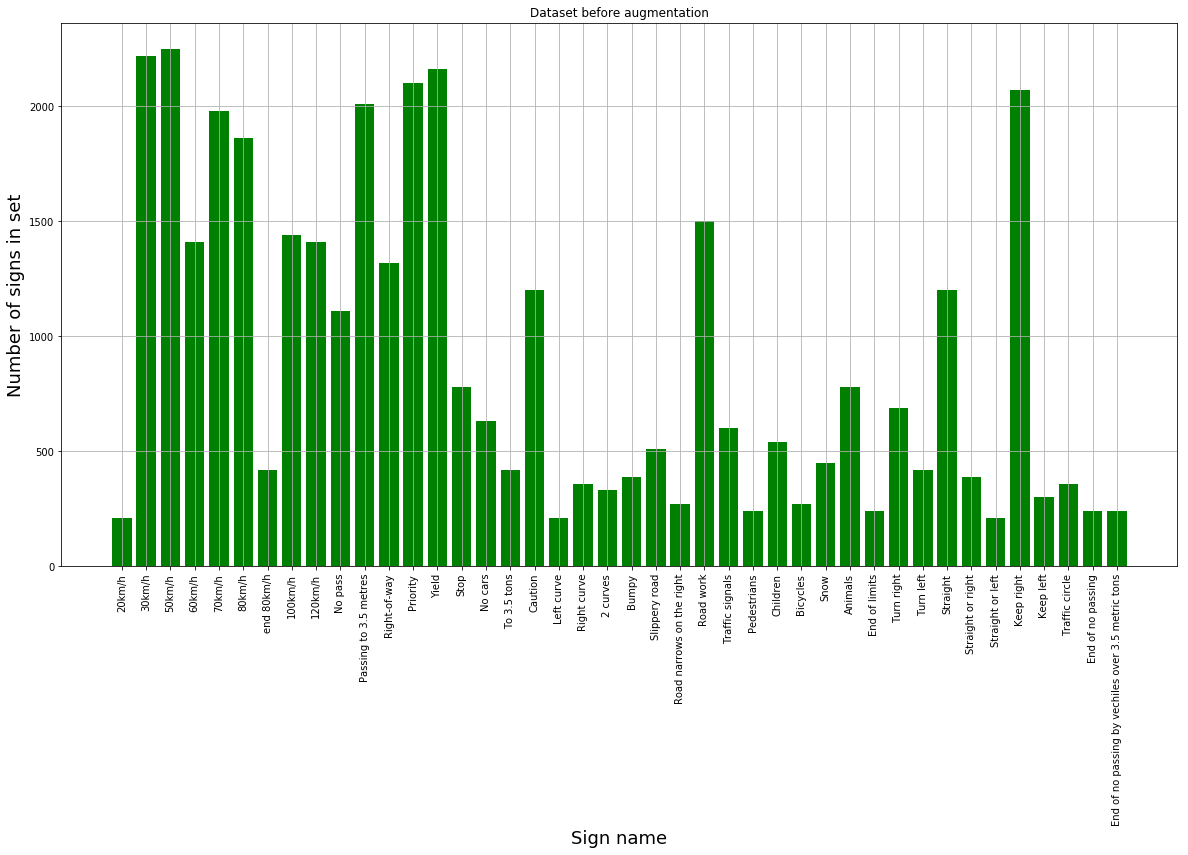

In [6]:
plot_bar(create_plot_date(images, sign_labels_dict), "Dataset before augmentation")

In [7]:
#TODO Improve pre-procesing: maybe image normalisation, some better augmentation (what about manipulating image brightness)
transformation = Transformation(images)
transformation.run() 

In [8]:
images_after_transformation = transformation.get_images() 

In [9]:
X, Y = transformation.get_formatted_dataset()
X, Y = shuffle(X,Y)

In [ ]:
print(len(X))
print(len(Y))
print(Y[1])
plt.imshow(X[1], cmap="gray")
plt.show()

In [ ]:
#print_signs(images)

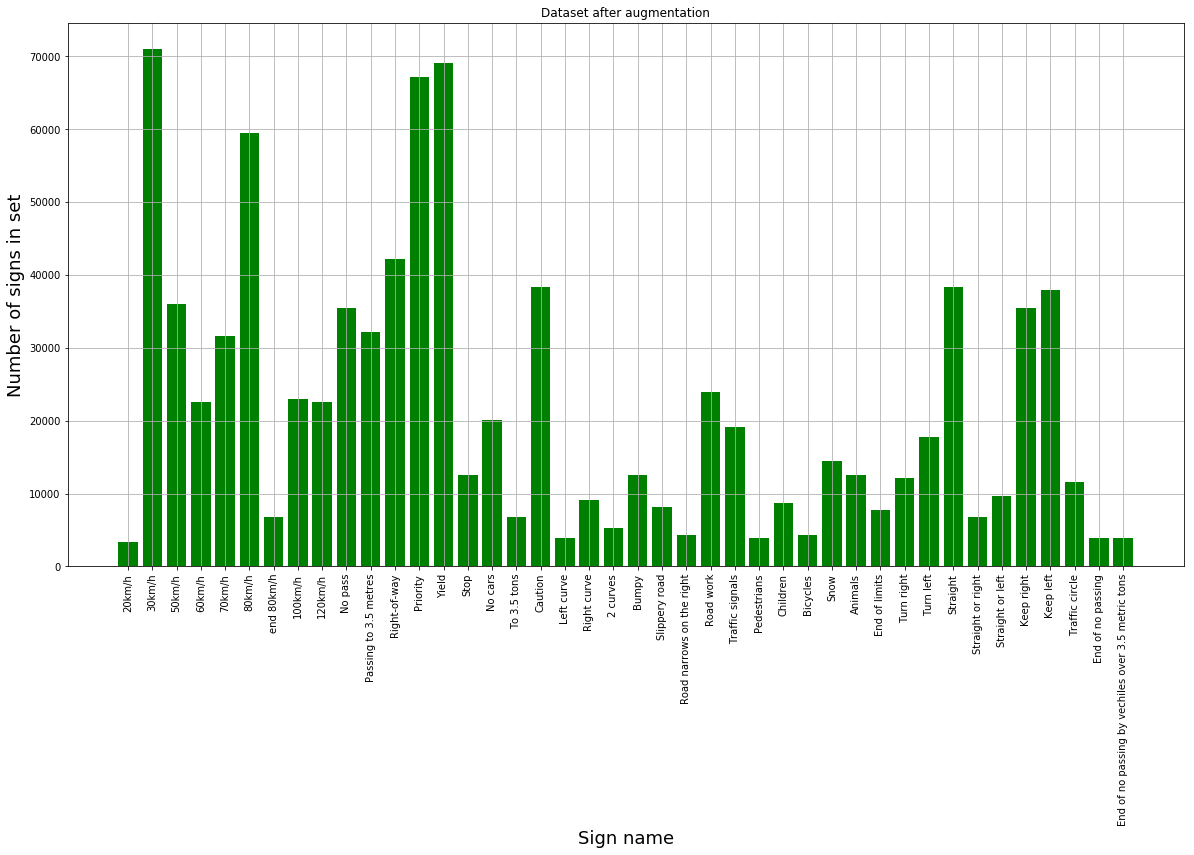

In [10]:
plot_bar(create_plot_date(images_after_transformation, sign_labels_dict), "Dataset after augmentation")

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
print(len(X))
print(len(X_train)+len(X_test))
print(len(Y))
print(len(Y_train)+len(Y_test))

In [ ]:
patent = "test"
def cnn_model_fn(features, labels, mode):
    is_training = True if mode == tf.estimator.ModeKeys.TRAIN else False
    is_predicting = True if mode == tf.estimator.ModeKeys.PREDICT else False
    is_evaling = True if mode == tf.estimator.ModeKeys.EVAL else False

    #print(optimizer_type)
    input_layer = tf.reshape(
        features, 
        [-1, 32, 32, 1]
    )
    print(patent)
    #TODO Rethink of schema. http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

    #input  -> 
    #conv_1 -> pool_1  -> drop_1  ->
    #conv_2 -> pool_2  -> drop_2  -> 
    #conv_3 -> pool_3  -> drop_3  ->
    #flat   -> fc      -> drop_fc -> softmax
     
    #TODO Adjust dropouts depends on layer deep:http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
    #TODO Rethink of initializer (random, xavier, He-et-al)

    conv_layer_1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 32,
        kernel_size = 5,
        padding = 'same',
        activation = tf.nn.relu
    )
    
    pooling_layer_1 = tf.layers.max_pooling2d(
        inputs = conv_layer_1, 
        pool_size = [2, 2], 
        strides = 2
    )
    
    dropout_layer_1 = tf.layers.dropout(
        inputs = pooling_layer_1, 
        rate = 0.1, 
        training = is_training
    )    
    
    conv_layer_2 = tf.layers.conv2d(
        inputs = dropout_layer_1,
        filters = 64,
        kernel_size = 5,
        padding = 'same',
        activation = tf.nn.relu
    )
    
    pooling_layer_2 = tf.layers.max_pooling2d(
        inputs = conv_layer_2, 
        pool_size = [2, 2], 
        strides = 2
    )
    
    dropout_layer_2 = tf.layers.dropout(
        inputs = pooling_layer_2, 
        rate = 0.2, 
        training = is_training
    )  
    
    
    conv_layer_3 = tf.layers.conv2d(
        inputs = dropout_layer_2,
        filters = 128,
        kernel_size = 5,
        padding = 'same',
        activation = tf.nn.relu    
    )
    
    pooling_layer_3 = tf.layers.max_pooling2d(
        inputs = conv_layer_3, 
        pool_size = [2, 2], 
        strides = 2
    )
    
    dropout_layer_3 = tf.layers.dropout(
        inputs = pooling_layer_3, 
        rate = 0.3, 
        training = is_training
    )
    
    
    flatten_layer = tf.reshape(
        dropout_layer_3, 
        [-1, 4 * 4 * 128]
    )
    #TODO Adjust neurons in full connection layer 
    #(by experimenting https://datascience.stackexchange.com/questions/22760/number-and-size-of-dense-layers-in-a-cnn)
    full_connection_layer = tf.layers.dense(
        inputs = flatten_layer, 
        units = 1024, 
        activation = tf.nn.relu
    )
    
    dropout_layer_4 = tf.layers.dropout(
        inputs = full_connection_layer, 
        rate = 0.4, 
        training = is_training
    )

    #softmax
    #logits = tf.layers.dense(inputs=dropout, units=43)

    softmax_layer = tf.layers.dense(
        inputs = dropout_layer_4, 
        units = len(sign_labels_dict)
    )

    predictions = {
        "classes": tf.argmax(
            input = softmax_layer, 
            axis = 1
        ),
        "probabilities": tf.nn.softmax(
            logits = softmax_layer, 
            name = "softmax"
        )
    }

    if is_predicting:
        return tf.estimator.EstimatorSpec(
            mode = mode, 
            predictions = predictions
        )

    if is_training or is_evaling:
        loss = tf.losses.sparse_softmax_cross_entropy(
            labels = labels, 
            logits = softmax_layer
        )

        if is_training:
            #https://arxiv.org/abs/1712.07628
            #https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
            #optimizers with different learning rate (at init 0.001)
            #TODO change optimizer depending on steps
            #global_step_value = 500
            '''
            global_step = tf.train.get_global_step()
            train_optimizer = tf.cond(tf.less(global_step_value, 1500),
                lambda: tf.train.AdamOptimizer().minimize(
                    loss = loss,
                    global_step = global_step
                ),
                lambda: tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(
                    loss = loss,
                    global_step = global_step
                )
            )
            '''
            train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(
                loss = loss,
                global_step = tf.train.get_global_step()
            )
            '''
            train_optimizer =  tf.train.AdamOptimizer().minimize(
                loss = loss,
                global_step = tf.train.get_global_step()
            )
            '''
            return tf.estimator.EstimatorSpec(
                mode = mode, 
                loss = loss, 
                train_op = train_optimizer
            )

        if is_evaling:
            metrics = {
                "accuracy": tf.metrics.accuracy(
                    labels = labels, 
                    predictions = predictions["classes"]
                )
            }
            return tf.estimator.EstimatorSpec(
                mode = mode, 
                loss = loss, 
                eval_metric_ops = metrics
            )

In [ ]:
#Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn = cnn_model_fn, 
    model_dir = "./tmp"
)

In [ ]:
#it's only for testing purpose, in normal training I will use full dataset
X1 = X_train[:20]
Y1 = Y_train[:20]
X2 = X_test[:100]
Y2 = Y_test[:100]

In [ ]:
logging_hook = tf.train.LoggingTensorHook(
    tensors = {
        "probabilities": "softmax"
    }, 
    every_n_iter = 25
)


In [ ]:
import csv
import sys
Y_train= Y_train.astype(np.int64)
Y_test= Y_test.astype(np.int64)

results = []
optimizers = ['adam', 'sgd']
optimizer = "sgd"
steps = [100]

lrs = [0.01, 0.001, 0.0001, 0.00001]
i = 0
for step in steps:
    def cnn_model_fn(features, labels, mode):
        is_training = True if mode == tf.estimator.ModeKeys.TRAIN else False
        is_predicting = True if mode == tf.estimator.ModeKeys.PREDICT else False
        is_evaling = True if mode == tf.estimator.ModeKeys.EVAL else False

        #print(optimizer_type)
        input_layer = tf.reshape(
            features, 
            [-1, 32, 32, 1]
        )

        #TODO Rethink of schema. http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

        #input  -> 
        #conv_1 -> pool_1  -> drop_1  ->
        #conv_2 -> pool_2  -> drop_2  -> 
        #conv_3 -> pool_3  -> drop_3  ->
        #flat   -> fc      -> drop_fc -> softmax

        #TODO Adjust dropouts depends on layer deep:http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
        #TODO Rethink of initializer (random, xavier, He-et-al)

        conv_layer_1 = tf.layers.conv2d(
            inputs = input_layer,
            filters = 32,
            kernel_size = 5,
            padding = 'same',
            activation = tf.nn.relu
        )

        pooling_layer_1 = tf.layers.max_pooling2d(
            inputs = conv_layer_1, 
            pool_size = [2, 2], 
            strides = 2
        )

        dropout_layer_1 = tf.layers.dropout(
            inputs = pooling_layer_1, 
            rate = 0.1, 
            training = is_training
        )    

        conv_layer_2 = tf.layers.conv2d(
            inputs = dropout_layer_1,
            filters = 64,
            kernel_size = 5,
            padding = 'same',
            activation = tf.nn.relu
        )

        pooling_layer_2 = tf.layers.max_pooling2d(
            inputs = conv_layer_2, 
            pool_size = [2, 2], 
            strides = 2
        )

        dropout_layer_2 = tf.layers.dropout(
            inputs = pooling_layer_2, 
            rate = 0.2, 
            training = is_training
        )  


        conv_layer_3 = tf.layers.conv2d(
            inputs = dropout_layer_2,
            filters = 128,
            kernel_size = 5,
            padding = 'same',
            activation = tf.nn.relu    
        )

        pooling_layer_3 = tf.layers.max_pooling2d(
            inputs = conv_layer_3, 
            pool_size = [2, 2], 
            strides = 2
        )

        dropout_layer_3 = tf.layers.dropout(
            inputs = pooling_layer_3, 
            rate = 0.3, 
            training = is_training
        )


        flatten_layer = tf.reshape(
            dropout_layer_3, 
            [-1, 4 * 4 * 128]
        )
        #TODO Adjust neurons in full connection layer 
        #(by experimenting https://datascience.stackexchange.com/questions/22760/number-and-size-of-dense-layers-in-a-cnn)
        full_connection_layer = tf.layers.dense(
            inputs = flatten_layer, 
            units = 1024, 
            activation = tf.nn.relu
        )

        dropout_layer_4 = tf.layers.dropout(
            inputs = full_connection_layer, 
            rate = 0.4, 
            training = is_training
        )

        #softmax
        softmax_layer = tf.layers.dense(
            inputs = dropout_layer_4, 
            units = len(sign_labels_dict)
        )

        predictions = {
            "classes": tf.argmax(
                input = softmax_layer, 
                axis = 1
            ),
            "probabilities": tf.nn.softmax(
                logits = softmax_layer, 
                name = "softmax"
            )
        }

        if is_predicting:
            return tf.estimator.EstimatorSpec(
                mode = mode, 
                predictions = predictions
            )

        
        if is_training or is_evaling:
            #https://stackoverflow.com/questions/47034888/how-to-choose-cross-entropy-loss-in-tensorflow
            loss = tf.losses.sparse_softmax_cross_entropy(
                labels = labels, 
                logits = softmax_layer
            )

            if is_training:
                #https://arxiv.org/abs/1712.07628
                #https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
                #optimizers with different learning rate (at init 0.001)
                #TODO change optimizer depending on steps
                #global_step_value = 500
                '''
                global_step = tf.train.get_global_step()
                train_optimizer = tf.cond(tf.less(global_step_value, 1500),
                    lambda: tf.train.AdamOptimizer().minimize(
                        loss = loss,
                        global_step = global_step
                    ),
                    lambda: tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(
                        loss = loss,
                        global_step = global_step
                    )
                )
                '''
                train_optimizer =  tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(
                    loss = loss,
                    global_step = tf.train.get_global_step()
                )
                
                accuracy = tf.metrics.accuracy(
                    labels = labels, 
                    predictions = predictions["classes"],
                    name = "accuracy"
                )
                
                mse = tf.metrics.mean_absolute_error(
                    labels = labels, 
                    predictions = predictions["classes"],
                    name = "mse"
                )

                tf.summary.scalar("accuracy", accuracy[1])
                tf.summary.scalar("MSE", mse[1])

                eval_metric_ops = {
                    "accuracy" : accuracy,
                    "MSE" : mse
                }

                return tf.estimator.EstimatorSpec(
                    mode = mode, 
                    loss = loss, 
                    train_op = train_optimizer,
                    eval_metric_ops = eval_metric_ops
                )

            if is_evaling:
                accuracy = tf.metrics.accuracy(
                    labels = labels, 
                    predictions = predictions["classes"],
                    name = "accuracy"
                )
                mse = tf.metrics.mean_absolute_error(
                    labels = labels, 
                    predictions = predictions["classes"],
                    name = "mse"
                )

                tf.summary.scalar("accuracy", accuracy[1])
                tf.summary.scalar("MSE", mse[1])

                eval_metric_ops = {
                    "accuracy" : accuracy,
                    "MSE" : mse
                }
                return tf.estimator.EstimatorSpec(
                    mode = mode, 
                    loss = loss, 
                    eval_metric_ops = eval_metric_ops
                )

    config = tf.estimator.RunConfig(
        save_summary_steps = 10,
        model_dir = "./"+optimizer+str(i)
    )

    #Create the Estimator
    classifier = tf.estimator.Estimator(
        model_fn = cnn_model_fn, 
        config = config
    )

    logging_hook = tf.train.LoggingTensorHook(
        tensors = {
            "probabilities": "softmax"
        },
        every_n_iter = 25
    )

    #Perform training model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = X_train,
        y = Y_train,
        batch_size = 100,
        num_epochs = None,
        shuffle = True
    )
    #Steps should be set to something bigger (need to adjust it)
    classifier.train(
        input_fn = train_input_fn,
        steps = step,
        hooks = [logging_hook]
    )
    # Evaluating the model
    evaluating_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = X_test,
        y = Y_test,
        num_epochs = 1,
        shuffle = False
    )
    print (classifier.evaluate(input_fn = evaluating_input_fn))
    i = i + 1


In [ ]:
    with open('result_list.csv', 'a') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([i,step,0.001,'adam+sgd'])
    i = i + 1

def get_formatted_dataset(images, y = [], x = []):
    for label in images:
        feature = re.sub(
                    r"Signs/Final_Training/Images/(.*)",
                    r"\1",
                    label
                )
        feature = int(feature)
        for image in images[label]:
            x.append(image)
            y.append(feature)
    return (np.array(x).astype(np.float32), np.array(y).astype(np.int32))

x3, y3 = get_formatted_dataset(images)

In [ ]:
# Evaluating the model
evaluating_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = x3,
    y = y3,
    num_epochs = 1,
    shuffle = False
)
print (classifier.evaluate(input_fn = evaluating_input_fn))

In [ ]:
# Evaluating the model
evaluating_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = X_test,
    y = Y_test,
    num_epochs = 1,
    shuffle = False
)
print (classifier.evaluate(input_fn = evaluating_input_fn))

In [14]:
import csv
import sys

Y_train = Y_train.astype(np.int64)
Y_test = Y_test.astype(np.int64)

optimizers = ['sgd']
steps = [3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,
         8500,9000,9500,10000,10500,11000,11500,12000,12500,13000]
lrs = [0.01, 0.001]
i = 30
for optimizer in optimizers:
    for step in steps:
        for lr in lrs:
            def cnn_model_fn(features, labels, mode):
                is_training = True if mode == tf.estimator.ModeKeys.TRAIN else False
                is_predicting = True if mode == tf.estimator.ModeKeys.PREDICT else False
                is_evaling = True if mode == tf.estimator.ModeKeys.EVAL else False

                input_layer = tf.reshape(
                    features, 
                    [-1, 32, 32, 1]
                )

                conv_layer_1 = tf.layers.conv2d(
                    inputs = input_layer,
                    filters = 32,
                    kernel_size = 5,
                    padding = 'same',
                    activation = tf.nn.relu
                )

                pooling_layer_1 = tf.layers.max_pooling2d(
                    inputs = conv_layer_1, 
                    pool_size = [2, 2], 
                    strides = 2
                )

                dropout_layer_1 = tf.layers.dropout(
                    inputs = pooling_layer_1, 
                    rate = 0.1, 
                    training = is_training
                )    

                conv_layer_2 = tf.layers.conv2d(
                    inputs = dropout_layer_1,
                    filters = 64,
                    kernel_size = 5,
                    padding = 'same',
                    activation = tf.nn.relu
                )

                pooling_layer_2 = tf.layers.max_pooling2d(
                    inputs = conv_layer_2, 
                    pool_size = [2, 2], 
                    strides = 2
                )

                dropout_layer_2 = tf.layers.dropout(
                    inputs = pooling_layer_2, 
                    rate = 0.2, 
                    training = is_training
                )  


                conv_layer_3 = tf.layers.conv2d(
                    inputs = dropout_layer_2,
                    filters = 128,
                    kernel_size = 5,
                    padding = 'same',
                    activation = tf.nn.relu    
                )

                pooling_layer_3 = tf.layers.max_pooling2d(
                    inputs = conv_layer_3, 
                    pool_size = [2, 2], 
                    strides = 2
                )

                dropout_layer_3 = tf.layers.dropout(
                    inputs = pooling_layer_3, 
                    rate = 0.3, 
                    training = is_training
                )


                flatten_layer = tf.reshape(
                    dropout_layer_3, 
                    [-1, 4 * 4 * 128]
                )

                full_connection_layer = tf.layers.dense(
                    inputs = flatten_layer, 
                    units = 1024, 
                    activation = tf.nn.relu
                )

                dropout_layer_4 = tf.layers.dropout(
                    inputs = full_connection_layer, 
                    rate = 0.4, 
                    training = is_training
                )

                #softmax
                softmax_layer = tf.layers.dense(
                    inputs = dropout_layer_4, 
                    units = len(sign_labels_dict)
                )

                predictions = {
                    "classes": tf.argmax(
                        input = softmax_layer, 
                        axis = 1
                    ),
                    "probabilities": tf.nn.softmax(
                        logits = softmax_layer, 
                        name = "softmax"
                    )
                }

                if is_predicting:
                    return tf.estimator.EstimatorSpec(
                        mode = mode, 
                        predictions = predictions
                    )

                loss = tf.losses.sparse_softmax_cross_entropy(
                    labels = labels, 
                    logits = softmax_layer
                )
                accuracy = tf.metrics.accuracy(
                    labels = labels, 
                    predictions = predictions["classes"]
                )

                mae = tf.metrics.mean_absolute_error(
                    labels = labels, 
                    predictions = predictions["classes"]
                )
                mse = tf.metrics.mean_squared_error(
                    labels = labels, 
                    predictions = predictions["classes"]
                )

                metrics = {
                    "accuracy" : accuracy,
                    "mae": mae,
                    "mse": mse
                }

                tf.summary.scalar("accuracy", accuracy[1])
                tf.summary.scalar("loss", loss)
                tf.logging.set_verbosity(tf.logging.INFO)
                tf.summary.merge_all()

                if is_training:
                    if optimizer == 'adam':
                        train_optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(
                            loss = loss,
                            global_step = tf.train.get_global_step()
                        )
                    elif optimizer == 'sgd':
                        train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(
                            loss = loss,
                            global_step = tf.train.get_global_step()
                        )

                    return tf.estimator.EstimatorSpec(
                        mode = mode, 
                        loss = loss, 
                        train_op = train_optimizer
                    )

                if is_evaling:
                    return tf.estimator.EstimatorSpec(
                        mode = mode, 
                        loss = loss, 
                        eval_metric_ops = metrics
                    )

            
            config = tf.estimator.RunConfig(
                save_summary_steps = 10,
                model_dir = "./sgd/" + str(i)
            )

            classifier = tf.estimator.Estimator(
                model_fn = cnn_model_fn, 
                config = config
            )

            train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x = X_train,
                y = Y_train,
                batch_size = 100,
                num_epochs = None,
                shuffle = True
            )

            classifier.train(
                input_fn = train_input_fn,
                steps = step
            )

            evaluating_input_fn = tf.estimator.inputs.numpy_input_fn(
                x = X_test,
                y = Y_test,
                num_epochs = 1,
                shuffle = False
            )
            output = classifier.evaluate(input_fn = evaluating_input_fn)
            output =  re.findall(
                r"{'accuracy': (.*), 'loss': (.*), 'mae': (.*), 'mse': (.*), 'global_step': (.*)}",
                str(output)
            )
            acc = output[0][0]
            loss = output[0][1]
            mae = output[0][2]
            mse = output[0][3]
            with open('result_list2.csv', 'a') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([i,optimizer,step, lr,acc,loss,mae,mse])
            i = i + 1

INFO:tensorflow:Using config: {'_model_dir': './adam_additional/21', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x15cdf3eb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./adam_additional/21/model.ckpt.
INFO:tensorflow:loss = 29.14611, step = 1


INFO:tensorflow:loss = 0.2712085, step = 7001 (31.736 sec)
INFO:tensorflow:global_step/sec: 3.13281
INFO:tensorflow:loss = 0.15424068, step = 7101 (31.921 sec)
INFO:tensorflow:global_step/sec: 3.15773
INFO:tensorflow:loss = 0.30198586, step = 7201 (31.668 sec)
INFO:tensorflow:global_step/sec: 3.07225
INFO:tensorflow:loss = 0.30932805, step = 7301 (32.549 sec)
INFO:tensorflow:Saving checkpoints for 7398 into ./adam_additional/21/model.ckpt.
INFO:tensorflow:global_step/sec: 3.14191
INFO:tensorflow:loss = 0.10249743, step = 7401 (31.828 sec)
INFO:tensorflow:global_step/sec: 3.12542
INFO:tensorflow:loss = 0.41179004, step = 7501 (31.996 sec)
INFO:tensorflow:global_step/sec: 3.24279
INFO:tensorflow:loss = 0.14100502, step = 7601 (30.837 sec)
INFO:tensorflow:global_step/sec: 3.0916
INFO:tensorflow:loss = 0.14531739, step = 7701 (32.346 sec)
INFO:tensorflow:global_step/sec: 3.0508
INFO:tensorflow:loss = 0.29590258, step = 7801 (32.778 sec)
INFO:tensorflow:global_step/sec: 2.89807
INFO:tensorf

INFO:tensorflow:loss = 0.28667018, step = 5301 (25.735 sec)
INFO:tensorflow:global_step/sec: 3.8672
INFO:tensorflow:loss = 0.44707328, step = 5401 (25.858 sec)
INFO:tensorflow:global_step/sec: 3.84124
INFO:tensorflow:loss = 0.28551018, step = 5501 (26.034 sec)
INFO:tensorflow:global_step/sec: 3.86795
INFO:tensorflow:loss = 0.22089468, step = 5601 (25.854 sec)
INFO:tensorflow:global_step/sec: 3.86859
INFO:tensorflow:loss = 0.3372705, step = 5701 (25.849 sec)
INFO:tensorflow:global_step/sec: 3.87186
INFO:tensorflow:loss = 0.18308675, step = 5801 (25.828 sec)
INFO:tensorflow:global_step/sec: 3.92637
INFO:tensorflow:loss = 0.32016024, step = 5901 (25.469 sec)
INFO:tensorflow:global_step/sec: 3.86639
INFO:tensorflow:loss = 0.3634764, step = 6001 (25.864 sec)
INFO:tensorflow:global_step/sec: 3.88198
INFO:tensorflow:loss = 0.26456913, step = 6101 (25.760 sec)
INFO:tensorflow:global_step/sec: 3.90831
INFO:tensorflow:loss = 0.15161435, step = 6201 (25.586 sec)
INFO:tensorflow:global_step/sec: 3

INFO:tensorflow:global_step/sec: 3.93474
INFO:tensorflow:loss = 0.38930237, step = 3701 (25.415 sec)
INFO:tensorflow:global_step/sec: 3.9076
INFO:tensorflow:loss = 0.5102428, step = 3801 (25.591 sec)
INFO:tensorflow:global_step/sec: 3.89136
INFO:tensorflow:loss = 0.4227122, step = 3901 (25.698 sec)
INFO:tensorflow:global_step/sec: 3.94412
INFO:tensorflow:loss = 0.34471172, step = 4001 (25.354 sec)
INFO:tensorflow:global_step/sec: 3.88593
INFO:tensorflow:loss = 0.40626913, step = 4101 (25.734 sec)
INFO:tensorflow:global_step/sec: 3.89916
INFO:tensorflow:loss = 0.33425933, step = 4201 (25.647 sec)
INFO:tensorflow:global_step/sec: 3.92152
INFO:tensorflow:loss = 0.2226489, step = 4301 (25.501 sec)
INFO:tensorflow:global_step/sec: 3.88237
INFO:tensorflow:loss = 0.27782467, step = 4401 (25.757 sec)
INFO:tensorflow:global_step/sec: 3.9137
INFO:tensorflow:loss = 0.5542877, step = 4501 (25.552 sec)
INFO:tensorflow:global_step/sec: 3.92659
INFO:tensorflow:loss = 0.5311813, step = 4601 (25.467 se

INFO:tensorflow:global_step/sec: 3.88784
INFO:tensorflow:loss = 2.0276504, step = 1601 (25.721 sec)
INFO:tensorflow:global_step/sec: 3.90782
INFO:tensorflow:loss = 1.845784, step = 1701 (25.590 sec)
INFO:tensorflow:global_step/sec: 3.86936
INFO:tensorflow:loss = 1.6733966, step = 1801 (25.844 sec)
INFO:tensorflow:global_step/sec: 3.86028
INFO:tensorflow:loss = 1.7604787, step = 1901 (25.905 sec)
INFO:tensorflow:global_step/sec: 3.89242
INFO:tensorflow:loss = 1.7328849, step = 2001 (25.690 sec)
INFO:tensorflow:global_step/sec: 3.86943
INFO:tensorflow:loss = 1.5236812, step = 2101 (25.844 sec)
INFO:tensorflow:global_step/sec: 3.87841
INFO:tensorflow:loss = 1.162066, step = 2201 (25.784 sec)
INFO:tensorflow:global_step/sec: 3.92062
INFO:tensorflow:loss = 1.5658636, step = 2301 (25.506 sec)
INFO:tensorflow:Saving checkpoints for 2324 into ./adam_additional/24/model.ckpt.
INFO:tensorflow:global_step/sec: 3.83862
INFO:tensorflow:loss = 1.1352506, step = 2401 (26.051 sec)
INFO:tensorflow:glob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./adam_additional/25/model.ckpt.
INFO:tensorflow:loss = 48.885883, step = 1
INFO:tensorflow:global_step/sec: 3.64541
INFO:tensorflow:loss = 3.4819396, step = 101 (27.433 sec)
INFO:tensorflow:global_step/sec: 3.65852
INFO:tensorflow:loss = 3.19298, step = 201 (27.333 sec)
INFO:tensorflow:global_step/sec: 3.63379
INFO:tensorflow:loss = 2.5348337, step = 301 (27.520 sec)
INFO:tensorflow:global_step/sec: 3.65711
INFO:tensorflow:loss = 2.2806456, step = 401 (27.344 sec)
INFO:tensorflow:global_step/sec: 3.63547
INFO:tensorflow:loss = 1.3381069, step = 501 (27.507 sec)
INFO:tensorflow:global_step/sec: 3.63343
INFO:tensorflow:loss = 1.4633437, step = 601 (27.522 sec)
INFO:tensorflow:global_step/sec: 3.64032
INFO:ten

INFO:tensorflow:global_step/sec: 3.92889
INFO:tensorflow:loss = 0.34424385, step = 7701 (25.452 sec)
INFO:tensorflow:global_step/sec: 3.93219
INFO:tensorflow:loss = 0.43051296, step = 7801 (25.431 sec)
INFO:tensorflow:global_step/sec: 3.933
INFO:tensorflow:loss = 0.078544736, step = 7901 (25.426 sec)
INFO:tensorflow:global_step/sec: 3.94981
INFO:tensorflow:loss = 0.20733163, step = 8001 (25.317 sec)
INFO:tensorflow:global_step/sec: 3.9559
INFO:tensorflow:loss = 0.27660772, step = 8101 (25.279 sec)
INFO:tensorflow:global_step/sec: 3.94004
INFO:tensorflow:loss = 0.32496446, step = 8201 (25.381 sec)
INFO:tensorflow:global_step/sec: 3.93521
INFO:tensorflow:loss = 0.47032085, step = 8301 (25.411 sec)
INFO:tensorflow:global_step/sec: 3.92999
INFO:tensorflow:loss = 0.4749262, step = 8401 (25.446 sec)
INFO:tensorflow:global_step/sec: 3.9739
INFO:tensorflow:loss = 0.26546624, step = 8501 (25.164 sec)
INFO:tensorflow:global_step/sec: 3.91361
INFO:tensorflow:loss = 0.07122708, step = 8601 (25.551

INFO:tensorflow:global_step/sec: 3.87921
INFO:tensorflow:loss = 0.3583711, step = 5101 (25.778 sec)
INFO:tensorflow:global_step/sec: 3.87125
INFO:tensorflow:loss = 0.5620115, step = 5201 (25.832 sec)
INFO:tensorflow:global_step/sec: 3.91303
INFO:tensorflow:loss = 0.5251664, step = 5301 (25.555 sec)
INFO:tensorflow:global_step/sec: 3.8599
INFO:tensorflow:loss = 0.412623, step = 5401 (25.908 sec)
INFO:tensorflow:global_step/sec: 3.88867
INFO:tensorflow:loss = 0.38122925, step = 5501 (25.715 sec)
INFO:tensorflow:global_step/sec: 3.88468
INFO:tensorflow:loss = 0.21057293, step = 5601 (25.742 sec)
INFO:tensorflow:global_step/sec: 3.71466
INFO:tensorflow:loss = 0.3493974, step = 5701 (26.921 sec)
INFO:tensorflow:global_step/sec: 3.68175
INFO:tensorflow:loss = 0.31790683, step = 5801 (27.161 sec)
INFO:tensorflow:global_step/sec: 3.88855
INFO:tensorflow:loss = 0.24151143, step = 5901 (25.716 sec)
INFO:tensorflow:global_step/sec: 3.94152
INFO:tensorflow:loss = 0.34259102, step = 6001 (25.371 se

INFO:tensorflow:loss = 0.38724375, step = 2401 (25.459 sec)
INFO:tensorflow:global_step/sec: 3.89522
INFO:tensorflow:loss = 0.43950114, step = 2501 (25.673 sec)
INFO:tensorflow:global_step/sec: 3.89965
INFO:tensorflow:loss = 0.336512, step = 2601 (25.643 sec)
INFO:tensorflow:global_step/sec: 3.90686
INFO:tensorflow:loss = 0.2956305, step = 2701 (25.596 sec)
INFO:tensorflow:global_step/sec: 3.89582
INFO:tensorflow:loss = 0.32918358, step = 2801 (25.669 sec)
INFO:tensorflow:global_step/sec: 3.89997
INFO:tensorflow:loss = 0.41314447, step = 2901 (25.641 sec)
INFO:tensorflow:global_step/sec: 3.92404
INFO:tensorflow:loss = 0.3601831, step = 3001 (25.484 sec)
INFO:tensorflow:global_step/sec: 3.9232
INFO:tensorflow:loss = 0.29660738, step = 3101 (25.490 sec)
INFO:tensorflow:global_step/sec: 3.91229
INFO:tensorflow:loss = 0.35617203, step = 3201 (25.561 sec)
INFO:tensorflow:global_step/sec: 3.92241
INFO:tensorflow:loss = 0.59063643, step = 3301 (25.494 sec)
INFO:tensorflow:global_step/sec: 3.9

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./adam_additional/28/model.ckpt.
INFO:tensorflow:loss = 37.269855, step = 1
INFO:tensorflow:global_step/sec: 3.58867
INFO:tensorflow:loss = 3.7454054, step = 101 (27.867 sec)
INFO:tensorflow:global_step/sec: 3.61656
INFO:tensorflow:loss = 3.6235867, step = 201 (27.651 sec)
INFO:tensorflow:global_step/sec: 3.58339
INFO:tensorflow:loss = 3.5615404, step = 301 (27.906 sec)
INFO:tensorflow:global_step/sec: 3.54365
INFO:tensorflow:loss = 3.4927092, step = 401 (28.220 sec)
INFO:tensorflow:global_step/sec: 3.4195
INFO:tensorflow:loss = 3.4676192, step = 501 (29.244 sec)
INFO:tensorflow:global_step/sec: 3.64851
INFO:tensorflow:loss = 3.5100534, step = 601 (27.408 sec)
INFO:tensorflow:global_step/sec: 3.60419
INFO:te

INFO:tensorflow:global_step/sec: 3.84681
INFO:tensorflow:loss = 0.36378396, step = 7701 (25.995 sec)
INFO:tensorflow:global_step/sec: 3.86519
INFO:tensorflow:loss = 0.31743518, step = 7801 (25.872 sec)
INFO:tensorflow:global_step/sec: 3.88828
INFO:tensorflow:loss = 0.22810434, step = 7901 (25.718 sec)
INFO:tensorflow:global_step/sec: 3.85806
INFO:tensorflow:loss = 0.1708108, step = 8001 (25.920 sec)
INFO:tensorflow:global_step/sec: 3.85834
INFO:tensorflow:loss = 0.19072329, step = 8101 (25.918 sec)
INFO:tensorflow:global_step/sec: 3.91098
INFO:tensorflow:loss = 0.2551599, step = 8201 (25.569 sec)
INFO:tensorflow:global_step/sec: 3.85097
INFO:tensorflow:loss = 0.3446989, step = 8301 (25.967 sec)
INFO:tensorflow:global_step/sec: 3.85434
INFO:tensorflow:loss = 0.13815537, step = 8401 (25.945 sec)
INFO:tensorflow:global_step/sec: 3.88624
INFO:tensorflow:loss = 0.2722825, step = 8501 (25.732 sec)
INFO:tensorflow:global_step/sec: 3.87823
INFO:tensorflow:loss = 0.22056474, step = 8601 (25.785

INFO:tensorflow:global_step/sec: 3.94786
INFO:tensorflow:loss = 0.6536484, step = 4601 (25.331 sec)
INFO:tensorflow:Saving checkpoints for 4678 into ./adam_additional/29/model.ckpt.
INFO:tensorflow:global_step/sec: 3.91933
INFO:tensorflow:loss = 0.49843237, step = 4701 (25.514 sec)
INFO:tensorflow:global_step/sec: 3.92788
INFO:tensorflow:loss = 0.5310338, step = 4801 (25.459 sec)
INFO:tensorflow:global_step/sec: 3.94878
INFO:tensorflow:loss = 0.5483599, step = 4901 (25.324 sec)
INFO:tensorflow:global_step/sec: 3.97069
INFO:tensorflow:loss = 0.34921333, step = 5001 (25.185 sec)
INFO:tensorflow:global_step/sec: 3.94112
INFO:tensorflow:loss = 0.53956777, step = 5101 (25.374 sec)
INFO:tensorflow:global_step/sec: 3.96447
INFO:tensorflow:loss = 0.24600118, step = 5201 (25.224 sec)
INFO:tensorflow:global_step/sec: 3.93865
INFO:tensorflow:loss = 0.6556516, step = 5301 (25.390 sec)
INFO:tensorflow:global_step/sec: 3.952
INFO:tensorflow:loss = 0.5019238, step = 5401 (25.304 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 3.88555
INFO:tensorflow:loss = 3.4755025, step = 901 (25.736 sec)
INFO:tensorflow:global_step/sec: 3.88986
INFO:tensorflow:loss = 3.3259, step = 1001 (25.708 sec)
INFO:tensorflow:global_step/sec: 3.93174
INFO:tensorflow:loss = 3.1392584, step = 1101 (25.434 sec)
INFO:tensorflow:global_step/sec: 3.89784
INFO:tensorflow:loss = 3.1571288, step = 1201 (25.655 sec)
INFO:tensorflow:global_step/sec: 3.9
INFO:tensorflow:loss = 3.1873837, step = 1301 (25.641 sec)
INFO:tensorflow:global_step/sec: 3.93456
INFO:tensorflow:loss = 2.9121888, step = 1401 (25.415 sec)
INFO:tensorflow:global_step/sec: 3.88572
INFO:tensorflow:loss = 2.7656631, step = 1501 (25.736 sec)
INFO:tensorflow:global_step/sec: 3.88855
INFO:tensorflow:loss = 2.7496567, step = 1601 (25.716 sec)
INFO:tensorflow:global_step/sec: 3.89899
INFO:tensorflow:loss = 2.3149097, step = 1701 (25.648 sec)
INFO:tensorflow:global_step/sec: 3.87759
INFO:tensorflow:loss = 2.340886, step = 1801 (25.789 sec)
INFO:tens

INFO:tensorflow:loss = 0.19628803, step = 8801 (25.740 sec)
INFO:tensorflow:global_step/sec: 3.89955
INFO:tensorflow:loss = 0.21696979, step = 8901 (25.647 sec)
INFO:tensorflow:global_step/sec: 3.88721
INFO:tensorflow:loss = 0.2708868, step = 9001 (25.722 sec)
INFO:tensorflow:global_step/sec: 3.90008
INFO:tensorflow:loss = 0.24663402, step = 9101 (25.641 sec)
INFO:tensorflow:global_step/sec: 3.9017
INFO:tensorflow:loss = 0.22256695, step = 9201 (25.630 sec)
INFO:tensorflow:global_step/sec: 3.90074
INFO:tensorflow:loss = 0.20811115, step = 9301 (25.636 sec)
INFO:tensorflow:Saving checkpoints for 9332 into ./adam_additional/30/model.ckpt.
INFO:tensorflow:global_step/sec: 3.84471
INFO:tensorflow:loss = 0.14996238, step = 9401 (26.009 sec)
INFO:tensorflow:global_step/sec: 3.8903
INFO:tensorflow:loss = 0.16003214, step = 9501 (25.705 sec)
INFO:tensorflow:global_step/sec: 3.89379
INFO:tensorflow:loss = 0.32997635, step = 9601 (25.682 sec)
INFO:tensorflow:global_step/sec: 3.89393
INFO:tensorf

INFO:tensorflow:global_step/sec: 3.63201
INFO:tensorflow:loss = 0.370984, step = 5101 (27.533 sec)
INFO:tensorflow:global_step/sec: 3.68893
INFO:tensorflow:loss = 0.2876772, step = 5201 (27.108 sec)
INFO:tensorflow:global_step/sec: 3.64562
INFO:tensorflow:loss = 0.42652038, step = 5301 (27.431 sec)
INFO:tensorflow:global_step/sec: 3.66549
INFO:tensorflow:loss = 0.24703874, step = 5401 (27.281 sec)
INFO:tensorflow:global_step/sec: 3.64085
INFO:tensorflow:loss = 0.2864413, step = 5501 (27.466 sec)
INFO:tensorflow:global_step/sec: 3.63034
INFO:tensorflow:loss = 0.3526004, step = 5601 (27.545 sec)
INFO:tensorflow:global_step/sec: 3.62559
INFO:tensorflow:loss = 0.18810514, step = 5701 (27.582 sec)
INFO:tensorflow:global_step/sec: 3.65541
INFO:tensorflow:loss = 0.16590834, step = 5801 (27.357 sec)
INFO:tensorflow:global_step/sec: 3.65911
INFO:tensorflow:loss = 0.2240852, step = 5901 (27.329 sec)
INFO:tensorflow:global_step/sec: 3.64702
INFO:tensorflow:loss = 0.22177441, step = 6001 (27.420 s

INFO:tensorflow:loss = 3.0707486, step = 901 (25.777 sec)
INFO:tensorflow:global_step/sec: 3.88891
INFO:tensorflow:loss = 2.769467, step = 1001 (25.714 sec)
INFO:tensorflow:global_step/sec: 3.91165
INFO:tensorflow:loss = 2.844732, step = 1101 (25.565 sec)
INFO:tensorflow:global_step/sec: 3.89516
INFO:tensorflow:loss = 2.716748, step = 1201 (25.673 sec)
INFO:tensorflow:global_step/sec: 3.88055
INFO:tensorflow:loss = 2.6000986, step = 1301 (25.770 sec)
INFO:tensorflow:global_step/sec: 3.90144
INFO:tensorflow:loss = 2.2004678, step = 1401 (25.631 sec)
INFO:tensorflow:global_step/sec: 3.8841
INFO:tensorflow:loss = 1.9104476, step = 1501 (25.746 sec)
INFO:tensorflow:global_step/sec: 3.88956
INFO:tensorflow:loss = 1.9385238, step = 1601 (25.710 sec)
INFO:tensorflow:global_step/sec: 3.90884
INFO:tensorflow:loss = 1.7639948, step = 1701 (25.583 sec)
INFO:tensorflow:global_step/sec: 3.86885
INFO:tensorflow:loss = 1.7039912, step = 1801 (25.847 sec)
INFO:tensorflow:global_step/sec: 3.90995
INFO:

INFO:tensorflow:global_step/sec: 3.86459
INFO:tensorflow:loss = 0.15645087, step = 8901 (25.876 sec)
INFO:tensorflow:global_step/sec: 3.89077
INFO:tensorflow:loss = 0.11081829, step = 9001 (25.702 sec)
INFO:tensorflow:global_step/sec: 3.87557
INFO:tensorflow:loss = 0.14335278, step = 9101 (25.802 sec)
INFO:tensorflow:global_step/sec: 3.87826
INFO:tensorflow:loss = 0.26184645, step = 9201 (25.785 sec)
INFO:tensorflow:global_step/sec: 3.86824
INFO:tensorflow:loss = 0.1283428, step = 9301 (25.851 sec)
INFO:tensorflow:Saving checkpoints for 9316 into ./adam_additional/32/model.ckpt.
INFO:tensorflow:global_step/sec: 3.86897
INFO:tensorflow:loss = 0.1895609, step = 9401 (25.847 sec)
INFO:tensorflow:global_step/sec: 3.85372
INFO:tensorflow:loss = 0.1691689, step = 9501 (25.950 sec)
INFO:tensorflow:global_step/sec: 3.85781
INFO:tensorflow:loss = 0.119783096, step = 9601 (25.920 sec)
INFO:tensorflow:global_step/sec: 3.92609
INFO:tensorflow:loss = 0.034458518, step = 9701 (25.471 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 3.88804
INFO:tensorflow:loss = 0.44259202, step = 4701 (25.720 sec)
INFO:tensorflow:global_step/sec: 3.91868
INFO:tensorflow:loss = 0.3087392, step = 4801 (25.519 sec)
INFO:tensorflow:global_step/sec: 3.9187
INFO:tensorflow:loss = 0.31767318, step = 4901 (25.518 sec)
INFO:tensorflow:global_step/sec: 3.91073
INFO:tensorflow:loss = 0.44721514, step = 5001 (25.571 sec)
INFO:tensorflow:global_step/sec: 3.90981
INFO:tensorflow:loss = 0.2165353, step = 5101 (25.577 sec)
INFO:tensorflow:global_step/sec: 3.91826
INFO:tensorflow:loss = 0.29610723, step = 5201 (25.522 sec)
INFO:tensorflow:global_step/sec: 3.90554
INFO:tensorflow:loss = 0.2831805, step = 5301 (25.604 sec)
INFO:tensorflow:global_step/sec: 3.93376
INFO:tensorflow:loss = 0.46476564, step = 5401 (25.420 sec)
INFO:tensorflow:global_step/sec: 3.85497
INFO:tensorflow:loss = 0.3531395, step = 5501 (25.941 sec)
INFO:tensorflow:global_step/sec: 3.70987
INFO:tensorflow:loss = 0.3237726, step = 5601 (26.955 s

INFO:tensorflow:loss = 37.16308, step = 1
INFO:tensorflow:global_step/sec: 3.57708
INFO:tensorflow:loss = 3.739143, step = 101 (27.957 sec)
INFO:tensorflow:global_step/sec: 3.57998
INFO:tensorflow:loss = 3.4651926, step = 201 (27.933 sec)
INFO:tensorflow:global_step/sec: 3.5517
INFO:tensorflow:loss = 3.5086098, step = 301 (28.158 sec)
INFO:tensorflow:global_step/sec: 3.55663
INFO:tensorflow:loss = 3.3566518, step = 401 (28.114 sec)
INFO:tensorflow:global_step/sec: 3.59692
INFO:tensorflow:loss = 3.4350476, step = 501 (27.802 sec)
INFO:tensorflow:global_step/sec: 3.59982
INFO:tensorflow:loss = 3.4058309, step = 601 (27.779 sec)
INFO:tensorflow:global_step/sec: 3.58163
INFO:tensorflow:loss = 3.4253137, step = 701 (27.921 sec)
INFO:tensorflow:global_step/sec: 3.60603
INFO:tensorflow:loss = 3.1341825, step = 801 (27.732 sec)
INFO:tensorflow:global_step/sec: 3.55751
INFO:tensorflow:loss = 3.0930943, step = 901 (28.109 sec)
INFO:tensorflow:global_step/sec: 3.58875
INFO:tensorflow:loss = 2.917

INFO:tensorflow:global_step/sec: 3.82403
INFO:tensorflow:loss = 0.23447493, step = 8001 (26.150 sec)
INFO:tensorflow:global_step/sec: 3.84122
INFO:tensorflow:loss = 0.11987436, step = 8101 (26.036 sec)
INFO:tensorflow:global_step/sec: 3.85133
INFO:tensorflow:loss = 0.25296, step = 8201 (25.963 sec)
INFO:tensorflow:global_step/sec: 3.828
INFO:tensorflow:loss = 0.20676804, step = 8301 (26.124 sec)
INFO:tensorflow:global_step/sec: 3.86497
INFO:tensorflow:loss = 0.25285208, step = 8401 (25.873 sec)
INFO:tensorflow:global_step/sec: 3.84827
INFO:tensorflow:loss = 0.17425075, step = 8501 (25.986 sec)
INFO:tensorflow:global_step/sec: 3.82605
INFO:tensorflow:loss = 0.07409686, step = 8601 (26.137 sec)
INFO:tensorflow:Saving checkpoints for 8610 into ./adam_additional/34/model.ckpt.
INFO:tensorflow:global_step/sec: 3.80317
INFO:tensorflow:loss = 0.1889828, step = 8701 (26.294 sec)
INFO:tensorflow:global_step/sec: 3.83015
INFO:tensorflow:loss = 0.13240092, step = 8801 (26.109 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 3.90464
INFO:tensorflow:loss = 0.3853944, step = 3301 (25.610 sec)
INFO:tensorflow:global_step/sec: 3.86896
INFO:tensorflow:loss = 0.35706165, step = 3401 (25.847 sec)
INFO:tensorflow:global_step/sec: 3.92282
INFO:tensorflow:loss = 0.39629337, step = 3501 (25.491 sec)
INFO:tensorflow:global_step/sec: 3.8541
INFO:tensorflow:loss = 0.4321009, step = 3601 (25.947 sec)
INFO:tensorflow:global_step/sec: 3.87301
INFO:tensorflow:loss = 0.6648874, step = 3701 (25.820 sec)
INFO:tensorflow:global_step/sec: 3.89007
INFO:tensorflow:loss = 0.37609446, step = 3801 (25.706 sec)
INFO:tensorflow:global_step/sec: 3.89216
INFO:tensorflow:loss = 0.3004873, step = 3901 (25.693 sec)
INFO:tensorflow:global_step/sec: 3.8827
INFO:tensorflow:loss = 0.3454904, step = 4001 (25.755 sec)
INFO:tensorflow:global_step/sec: 3.90009
INFO:tensorflow:loss = 0.28104302, step = 4101 (25.643 sec)
INFO:tensorflow:global_step/sec: 3.89858
INFO:tensorflow:loss = 0.4282661, step = 4201 (25.648 sec

INFO:tensorflow:loss = 0.18331733, step = 11101 (25.674 sec)
INFO:tensorflow:global_step/sec: 3.89187
INFO:tensorflow:loss = 0.32563838, step = 11201 (25.695 sec)
INFO:tensorflow:global_step/sec: 3.86947
INFO:tensorflow:loss = 0.4320239, step = 11301 (25.844 sec)
INFO:tensorflow:global_step/sec: 3.89781
INFO:tensorflow:loss = 0.4526259, step = 11401 (25.655 sec)
INFO:tensorflow:Saving checkpoints for 11500 into ./adam_additional/35/model.ckpt.
INFO:tensorflow:Loss for final step: 0.33901227.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-18-09:15:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./adam_additional/35/model.ckpt-11500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-18-09:17:27
INFO:tensorflow:Saving dict for global step 11500: accuracy = 0.97933835, global_step = 11500, loss = 0.07275206

INFO:tensorflow:global_step/sec: 3.74516
INFO:tensorflow:loss = 0.27199656, step = 6001 (26.701 sec)
INFO:tensorflow:global_step/sec: 3.83907
INFO:tensorflow:loss = 0.2862017, step = 6101 (26.048 sec)
INFO:tensorflow:global_step/sec: 3.79209
INFO:tensorflow:loss = 0.35584062, step = 6201 (26.371 sec)
INFO:tensorflow:global_step/sec: 3.81344
INFO:tensorflow:loss = 0.50464135, step = 6301 (26.223 sec)
INFO:tensorflow:global_step/sec: 3.64872
INFO:tensorflow:loss = 0.34958172, step = 6401 (27.407 sec)
INFO:tensorflow:global_step/sec: 3.78528
INFO:tensorflow:loss = 0.31514022, step = 6501 (26.419 sec)
INFO:tensorflow:global_step/sec: 3.82141
INFO:tensorflow:loss = 0.34822237, step = 6601 (26.168 sec)
INFO:tensorflow:global_step/sec: 3.81481
INFO:tensorflow:loss = 0.29793155, step = 6701 (26.213 sec)
INFO:tensorflow:global_step/sec: 3.7981
INFO:tensorflow:loss = 0.45841274, step = 6801 (26.329 sec)
INFO:tensorflow:Saving checkpoints for 6882 into ./adam_additional/36/model.ckpt.
INFO:tensor

INFO:tensorflow:loss = 0.8137331, step = 701 (28.047 sec)
INFO:tensorflow:global_step/sec: 3.52322
INFO:tensorflow:loss = 0.78809446, step = 801 (28.383 sec)
INFO:tensorflow:global_step/sec: 3.39643
INFO:tensorflow:loss = 0.9681261, step = 901 (29.443 sec)
INFO:tensorflow:global_step/sec: 3.11908
INFO:tensorflow:loss = 0.6130436, step = 1001 (32.060 sec)
INFO:tensorflow:global_step/sec: 3.57784
INFO:tensorflow:loss = 0.507713, step = 1101 (27.950 sec)
INFO:tensorflow:global_step/sec: 3.57314
INFO:tensorflow:loss = 0.62938935, step = 1201 (27.986 sec)
INFO:tensorflow:global_step/sec: 3.59144
INFO:tensorflow:loss = 0.43768138, step = 1301 (27.844 sec)
INFO:tensorflow:global_step/sec: 3.59126
INFO:tensorflow:loss = 0.41729867, step = 1401 (27.845 sec)
INFO:tensorflow:global_step/sec: 3.58033
INFO:tensorflow:loss = 0.40526506, step = 1501 (27.930 sec)
INFO:tensorflow:global_step/sec: 3.60055
INFO:tensorflow:loss = 0.505388, step = 1601 (27.774 sec)
INFO:tensorflow:global_step/sec: 3.58834


INFO:tensorflow:global_step/sec: 3.89896
INFO:tensorflow:loss = 0.3159798, step = 8701 (25.647 sec)
INFO:tensorflow:global_step/sec: 3.87533
INFO:tensorflow:loss = 0.37890387, step = 8801 (25.804 sec)
INFO:tensorflow:global_step/sec: 3.86601
INFO:tensorflow:loss = 0.3022309, step = 8901 (25.867 sec)
INFO:tensorflow:Saving checkpoints for 8959 into ./adam_additional/37/model.ckpt.
INFO:tensorflow:global_step/sec: 3.86487
INFO:tensorflow:loss = 0.18247099, step = 9001 (25.874 sec)
INFO:tensorflow:global_step/sec: 3.86792
INFO:tensorflow:loss = 0.4659426, step = 9101 (25.854 sec)
INFO:tensorflow:global_step/sec: 3.86134
INFO:tensorflow:loss = 0.16385993, step = 9201 (25.898 sec)
INFO:tensorflow:global_step/sec: 3.89438
INFO:tensorflow:loss = 0.37306955, step = 9301 (25.679 sec)
INFO:tensorflow:global_step/sec: 3.85391
INFO:tensorflow:loss = 0.5309604, step = 9401 (25.946 sec)
INFO:tensorflow:global_step/sec: 3.87915
INFO:tensorflow:loss = 0.49816057, step = 9501 (25.779 sec)
INFO:tensorfl

INFO:tensorflow:loss = 1.0124537, step = 2901 (26.100 sec)
INFO:tensorflow:global_step/sec: 3.82872
INFO:tensorflow:loss = 0.716434, step = 3001 (26.119 sec)
INFO:tensorflow:global_step/sec: 3.82603
INFO:tensorflow:loss = 1.1474078, step = 3101 (26.137 sec)
INFO:tensorflow:global_step/sec: 3.86187
INFO:tensorflow:loss = 0.72694904, step = 3201 (25.895 sec)
INFO:tensorflow:global_step/sec: 3.82504
INFO:tensorflow:loss = 0.7438455, step = 3301 (26.143 sec)
INFO:tensorflow:global_step/sec: 3.82174
INFO:tensorflow:loss = 0.911098, step = 3401 (26.166 sec)
INFO:tensorflow:global_step/sec: 3.82366
INFO:tensorflow:loss = 0.79838127, step = 3501 (26.153 sec)
INFO:tensorflow:global_step/sec: 3.87965
INFO:tensorflow:loss = 0.62921, step = 3601 (25.776 sec)
INFO:tensorflow:global_step/sec: 3.82222
INFO:tensorflow:loss = 0.6054923, step = 3701 (26.163 sec)
INFO:tensorflow:global_step/sec: 3.83885
INFO:tensorflow:loss = 0.8714631, step = 3801 (26.049 sec)
INFO:tensorflow:global_step/sec: 3.84523
IN

INFO:tensorflow:loss = 0.15510015, step = 10801 (31.090 sec)
INFO:tensorflow:global_step/sec: 3.18916
INFO:tensorflow:loss = 0.12845811, step = 10901 (31.356 sec)
INFO:tensorflow:global_step/sec: 3.19662
INFO:tensorflow:loss = 0.09837464, step = 11001 (31.283 sec)
INFO:tensorflow:Saving checkpoints for 11028 into ./adam_additional/38/model.ckpt.
INFO:tensorflow:global_step/sec: 3.19152
INFO:tensorflow:loss = 0.12882996, step = 11101 (31.333 sec)
INFO:tensorflow:global_step/sec: 3.22496
INFO:tensorflow:loss = 0.18175924, step = 11201 (31.008 sec)
INFO:tensorflow:global_step/sec: 3.1989
INFO:tensorflow:loss = 0.14629504, step = 11301 (31.261 sec)
INFO:tensorflow:global_step/sec: 3.1476
INFO:tensorflow:loss = 0.19973631, step = 11401 (31.771 sec)
INFO:tensorflow:global_step/sec: 2.95861
INFO:tensorflow:loss = 0.093235575, step = 11501 (33.800 sec)
INFO:tensorflow:global_step/sec: 3.54296
INFO:tensorflow:loss = 0.079409644, step = 11601 (28.224 sec)
INFO:tensorflow:global_step/sec: 3.8429


INFO:tensorflow:global_step/sec: 3.58557
INFO:tensorflow:loss = 0.2975402, step = 5101 (27.890 sec)
INFO:tensorflow:global_step/sec: 3.61141
INFO:tensorflow:loss = 0.33019736, step = 5201 (27.690 sec)
INFO:tensorflow:global_step/sec: 3.57557
INFO:tensorflow:loss = 0.33886626, step = 5301 (27.968 sec)
INFO:tensorflow:global_step/sec: 3.54929
INFO:tensorflow:loss = 0.33698222, step = 5401 (28.174 sec)
INFO:tensorflow:global_step/sec: 3.53688
INFO:tensorflow:loss = 0.28590474, step = 5501 (28.274 sec)
INFO:tensorflow:global_step/sec: 3.02927
INFO:tensorflow:loss = 0.32605818, step = 5601 (33.011 sec)
INFO:tensorflow:global_step/sec: 3.44599
INFO:tensorflow:loss = 0.37591115, step = 5701 (29.019 sec)
INFO:tensorflow:global_step/sec: 3.59939
INFO:tensorflow:loss = 0.13475117, step = 5801 (27.783 sec)
INFO:tensorflow:global_step/sec: 3.58619
INFO:tensorflow:loss = 0.17411233, step = 5901 (27.884 sec)
INFO:tensorflow:global_step/sec: 3.61209
INFO:tensorflow:loss = 0.20052123, step = 6001 (27.

INFO:tensorflow:Saving dict for global step 12500: accuracy = 0.9806267, global_step = 12500, loss = 0.06996006, mae = 0.17037202, mse = 3.2793074
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12500: ./adam_additional/39/model.ckpt-12500
INFO:tensorflow:Using config: {'_model_dir': './adam_additional/40', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1689cb8d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Check

INFO:tensorflow:Saving checkpoints for 6895 into ./adam_additional/40/model.ckpt.
INFO:tensorflow:global_step/sec: 3.84657
INFO:tensorflow:loss = 0.20288408, step = 6901 (25.997 sec)
INFO:tensorflow:global_step/sec: 3.78448
INFO:tensorflow:loss = 0.28766358, step = 7001 (26.424 sec)
INFO:tensorflow:global_step/sec: 3.85201
INFO:tensorflow:loss = 0.26629433, step = 7101 (25.961 sec)
INFO:tensorflow:global_step/sec: 3.82588
INFO:tensorflow:loss = 0.24440324, step = 7201 (26.138 sec)
INFO:tensorflow:global_step/sec: 3.83694
INFO:tensorflow:loss = 0.07658009, step = 7301 (26.063 sec)
INFO:tensorflow:global_step/sec: 3.83862
INFO:tensorflow:loss = 0.17167053, step = 7401 (26.051 sec)
INFO:tensorflow:global_step/sec: 3.85669
INFO:tensorflow:loss = 0.25574356, step = 7501 (25.929 sec)
INFO:tensorflow:global_step/sec: 3.86517
INFO:tensorflow:loss = 0.16044477, step = 7601 (25.872 sec)
INFO:tensorflow:global_step/sec: 3.83454
INFO:tensorflow:loss = 0.2120455, step = 7701 (26.079 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 3.86819
INFO:tensorflow:loss = 1.2120215, step = 601 (25.852 sec)
INFO:tensorflow:global_step/sec: 3.87206
INFO:tensorflow:loss = 1.492459, step = 701 (25.826 sec)
INFO:tensorflow:global_step/sec: 3.84453
INFO:tensorflow:loss = 0.956748, step = 801 (26.011 sec)
INFO:tensorflow:global_step/sec: 3.89617
INFO:tensorflow:loss = 0.93934363, step = 901 (25.667 sec)
INFO:tensorflow:global_step/sec: 3.8996
INFO:tensorflow:loss = 0.92699546, step = 1001 (25.644 sec)
INFO:tensorflow:global_step/sec: 3.87454
INFO:tensorflow:loss = 0.6534814, step = 1101 (25.809 sec)
INFO:tensorflow:global_step/sec: 3.85366
INFO:tensorflow:loss = 0.5979724, step = 1201 (25.949 sec)
INFO:tensorflow:global_step/sec: 3.87617
INFO:tensorflow:loss = 0.53756386, step = 1301 (25.798 sec)
INFO:tensorflow:global_step/sec: 3.85629
INFO:tensorflow:loss = 0.55241674, step = 1401 (25.932 sec)
INFO:tensorflow:global_step/sec: 3.86808
INFO:tensorflow:loss = 0.4978123, step = 1501 (25.853 sec)
INF

INFO:tensorflow:loss = 0.22056668, step = 8501 (24.668 sec)
INFO:tensorflow:global_step/sec: 3.99438
INFO:tensorflow:loss = 0.18417005, step = 8601 (25.035 sec)
INFO:tensorflow:global_step/sec: 3.89675
INFO:tensorflow:loss = 0.124631524, step = 8701 (25.663 sec)
INFO:tensorflow:global_step/sec: 3.86621
INFO:tensorflow:loss = 0.12451112, step = 8801 (25.865 sec)
INFO:tensorflow:global_step/sec: 3.86705
INFO:tensorflow:loss = 0.43473426, step = 8901 (25.860 sec)
INFO:tensorflow:global_step/sec: 3.9055
INFO:tensorflow:loss = 0.30492836, step = 9001 (25.605 sec)
INFO:tensorflow:global_step/sec: 3.8641
INFO:tensorflow:loss = 0.34795523, step = 9101 (25.879 sec)
INFO:tensorflow:global_step/sec: 3.86084
INFO:tensorflow:loss = 0.10922323, step = 9201 (25.901 sec)
INFO:tensorflow:global_step/sec: 3.87904
INFO:tensorflow:loss = 0.34272546, step = 9301 (25.780 sec)
INFO:tensorflow:Saving checkpoints for 9327 into ./adam_additional/41/model.ckpt.
INFO:tensorflow:global_step/sec: 3.54957
INFO:tenso

INFO:tensorflow:global_step/sec: 3.55753
INFO:tensorflow:loss = 1.6164668, step = 1901 (28.109 sec)
INFO:tensorflow:global_step/sec: 3.56154
INFO:tensorflow:loss = 1.6107693, step = 2001 (28.078 sec)
INFO:tensorflow:global_step/sec: 3.56285
INFO:tensorflow:loss = 1.7155626, step = 2101 (28.067 sec)
INFO:tensorflow:Saving checkpoints for 2125 into ./adam_additional/42/model.ckpt.
INFO:tensorflow:global_step/sec: 3.54885
INFO:tensorflow:loss = 1.4812906, step = 2201 (28.178 sec)
INFO:tensorflow:global_step/sec: 3.57845
INFO:tensorflow:loss = 1.6912162, step = 2301 (27.945 sec)
INFO:tensorflow:global_step/sec: 3.57472
INFO:tensorflow:loss = 1.4931883, step = 2401 (27.974 sec)
INFO:tensorflow:global_step/sec: 3.52634
INFO:tensorflow:loss = 1.5041596, step = 2501 (28.358 sec)
INFO:tensorflow:global_step/sec: 3.55349
INFO:tensorflow:loss = 1.0510472, step = 2601 (28.141 sec)
INFO:tensorflow:global_step/sec: 3.42788
INFO:tensorflow:loss = 1.2900544, step = 2701 (29.173 sec)
INFO:tensorflow:gl

INFO:tensorflow:loss = 0.121931896, step = 9701 (25.468 sec)
INFO:tensorflow:global_step/sec: 3.90264
INFO:tensorflow:loss = 0.11743947, step = 9801 (25.624 sec)
INFO:tensorflow:global_step/sec: 3.9159
INFO:tensorflow:loss = 0.12414957, step = 9901 (25.537 sec)
INFO:tensorflow:global_step/sec: 3.86966
INFO:tensorflow:loss = 0.11044875, step = 10001 (25.842 sec)
INFO:tensorflow:global_step/sec: 3.88677
INFO:tensorflow:loss = 0.157734, step = 10101 (25.728 sec)
INFO:tensorflow:global_step/sec: 3.8984
INFO:tensorflow:loss = 0.19509208, step = 10201 (25.652 sec)
INFO:tensorflow:global_step/sec: 3.88423
INFO:tensorflow:loss = 0.26494306, step = 10301 (25.745 sec)
INFO:tensorflow:global_step/sec: 3.89714
INFO:tensorflow:loss = 0.1324539, step = 10401 (25.660 sec)
INFO:tensorflow:global_step/sec: 3.81638
INFO:tensorflow:loss = 0.2586537, step = 10501 (26.203 sec)
INFO:tensorflow:global_step/sec: 3.59629
INFO:tensorflow:loss = 0.12035568, step = 10601 (27.806 sec)
INFO:tensorflow:global_step/s